<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/XPS_Spectrum/blob/main/XPSPrediction_New_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

32/32 [==============================] - 0s 3ms/step
R2 Score: 0.9460852106630923
RMSE: 0.06781778544435013


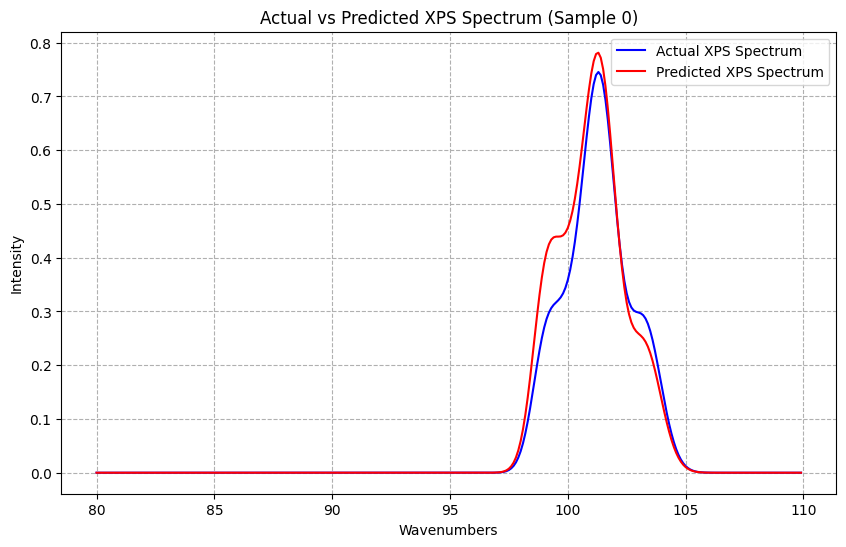

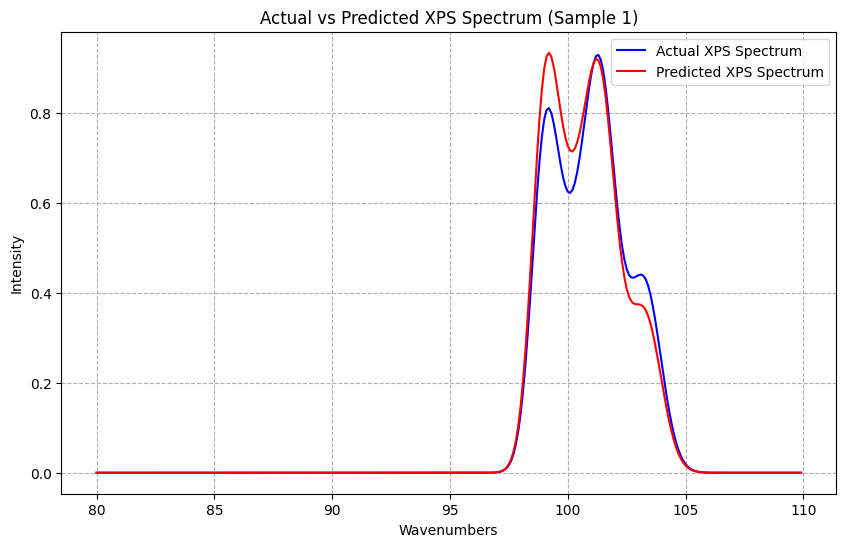

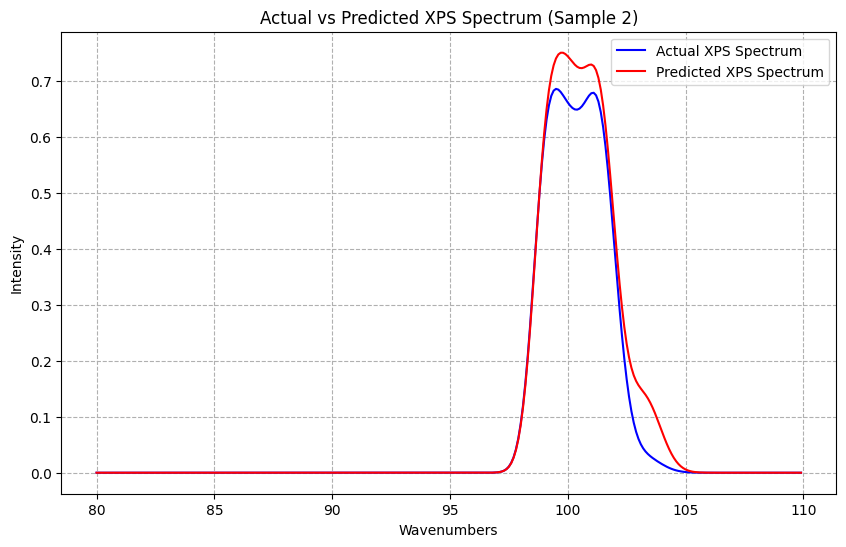

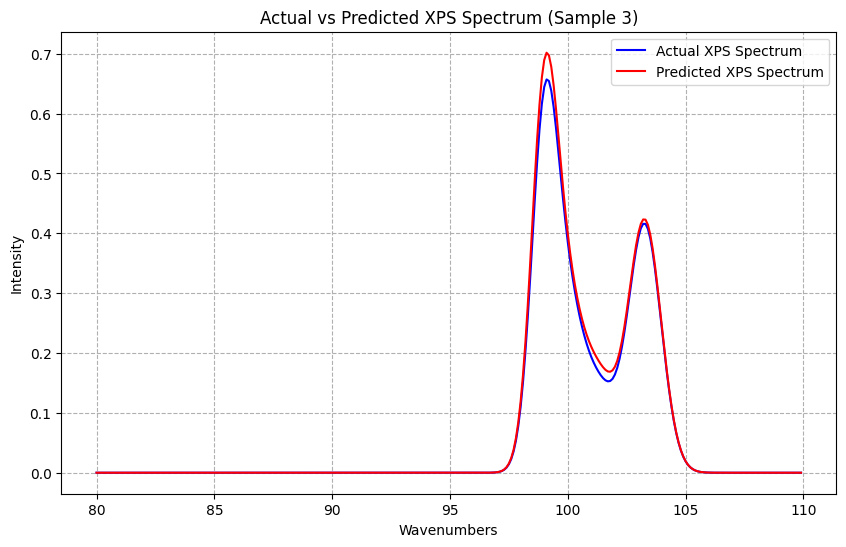

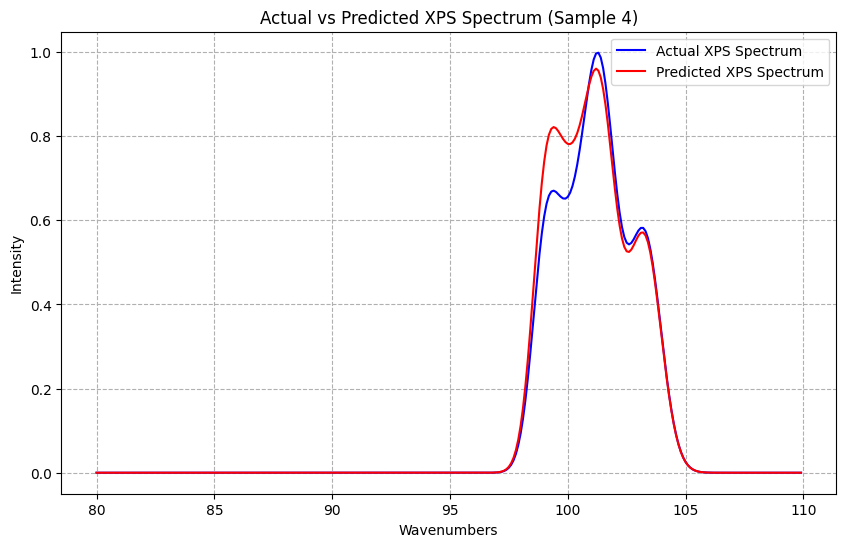

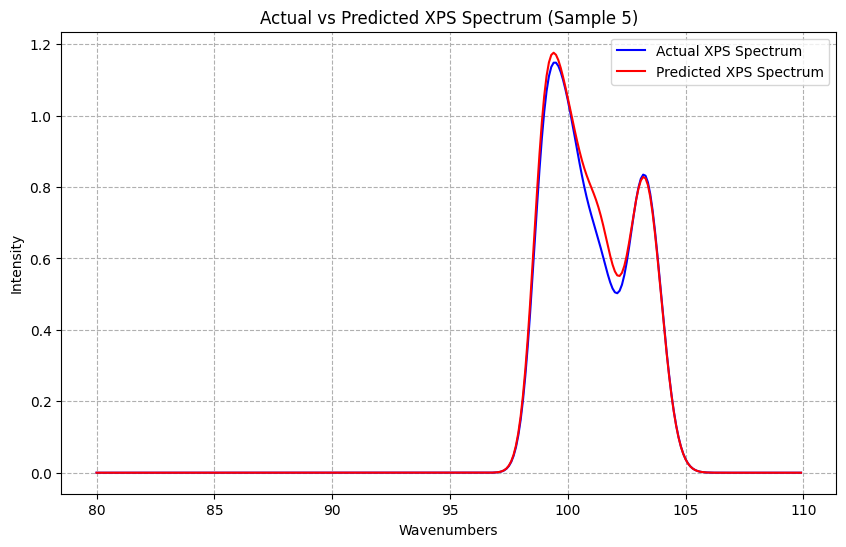

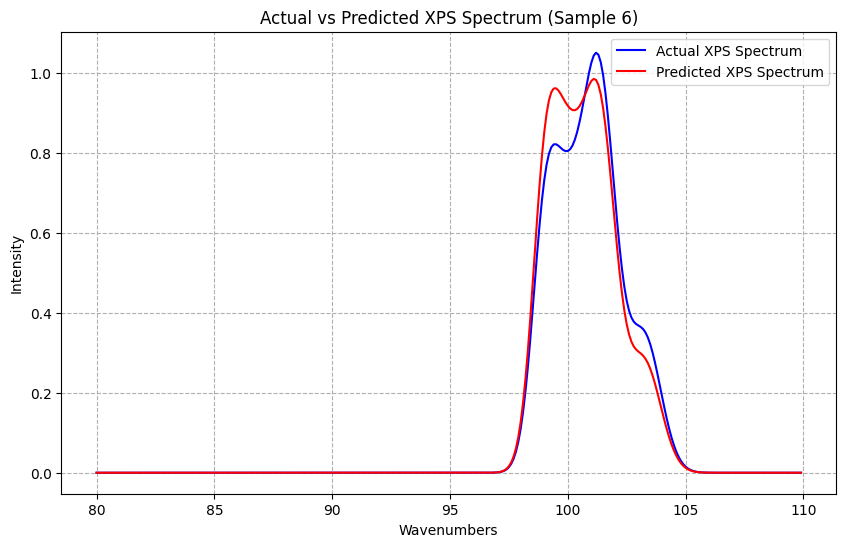

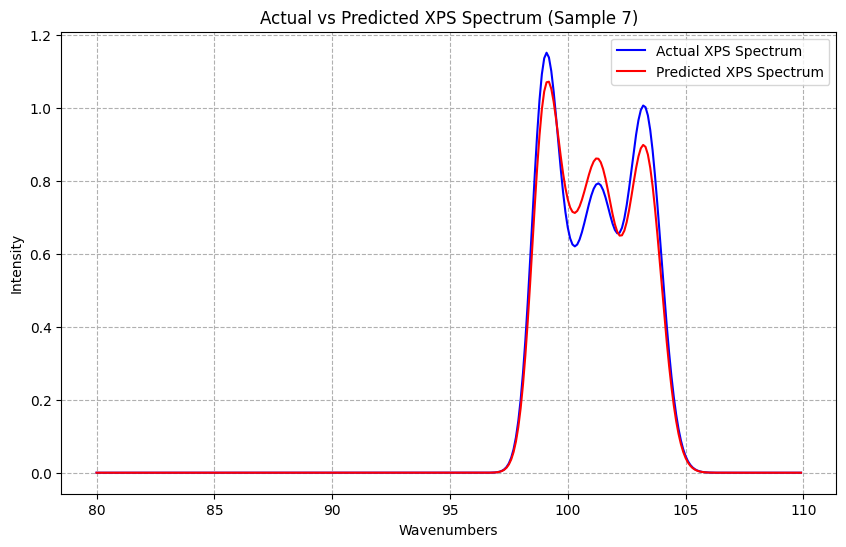

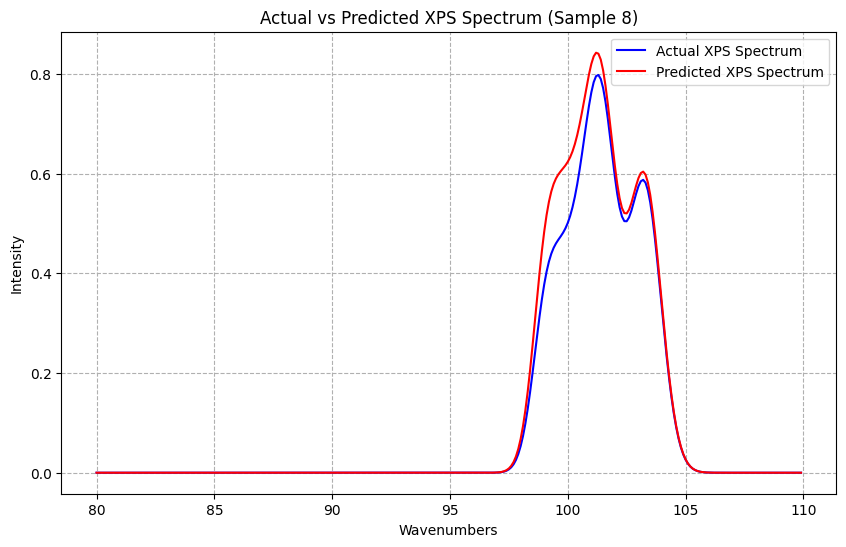

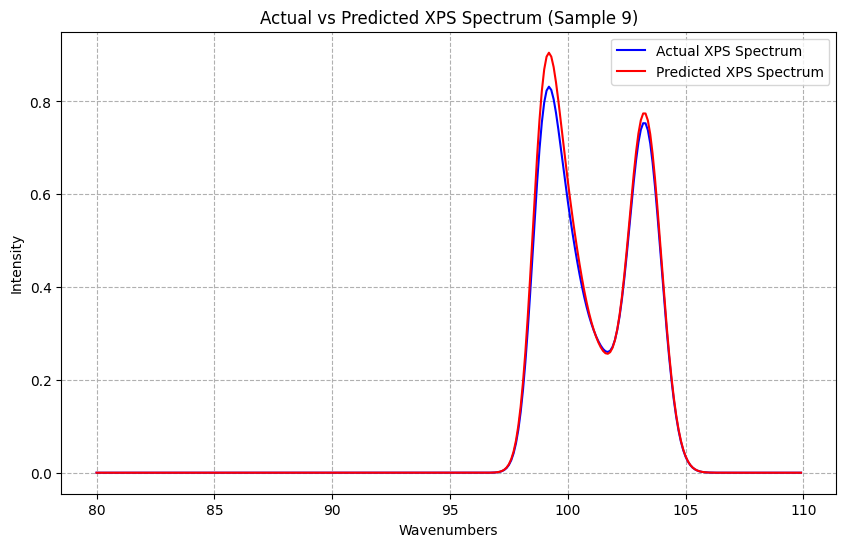

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import find_peaks

# Function to generate a spectrum as a sum of Gaussians
def generate_spectrum_sum_gaussians(amplitudes, centers, fwhms):
    x_range = np.arange(80, 110, 0.1)
    peaks = []
    for i in range(len(centers)):
        fwhm = fwhms[i]
        peak = amplitudes[i] * np.exp(-(x_range - centers[i])**2 / (2 * (fwhm / (2 * np.sqrt(2 * np.log(2)) ))**2))  # Gaussian peak with FWHM
        peaks.append(peak)
    return np.sum(peaks, axis=0), x_range

# Adjusted specific frequencies for synthetic data generation
adjustedFrequencies = {
    99.0 + np.random.uniform(-0.1, 0.1): ('Silicon (Si)', 1.30),
    100.4 + np.random.uniform(-0.5, 0.5): ('Silicon carbide (SiC)', 1.65),
    101.6 + np.random.uniform(-0.3, 0.3): ('Silicon nitride (SiN)', 1.65),
    103.1 + np.random.uniform(-0.3, 0.3): ('Silicon oxide (SiO2)', 1.65)
}

# Generate 5000 synthetic spectra and corresponding amplitudes
num_spectra = 5000
spectra = []
amplitudes_list = []
centers = list(adjustedFrequencies.keys())
fwhms = [fwhm for _, (_, fwhm) in adjustedFrequencies.items()]
for _ in range(num_spectra):
    amplitudes = np.random.rand(len(centers))
    spectrum, _ = generate_spectrum_sum_gaussians(amplitudes, centers, fwhms)
    spectra.append(spectrum)
    amplitudes_list.append(amplitudes)

spectra = np.array(spectra)
amplitudes_list = np.array(amplitudes_list)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(spectra, amplitudes_list, test_size=0.2, random_state=42)

# Reshape data for the DNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define the DNN model
model = Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], 1)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(centers), activation='relu')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Predictions
predictions = model.predict(X_test)

# Calculate R2 and RMSE
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("R2 Score:", r2)
print("RMSE:", rmse)

# Plotting actual spectrum and normalized predicted spectrum for 10 samples
num_samples_to_plot = 10

for idx in range(num_samples_to_plot):
    actual_spectrum = X_test[idx].flatten()  # Flatten the actual spectrum
    predicted_amplitudes = predictions[idx]

    # Generate the wavenumber range
    wavenumbers = np.arange(80, 110, 0.1)  # Assuming these are the correct wavenumbers

    # Function to generate spectrum based on the predicted amplitudes
    def generate_predicted_spectrum(amplitudes):
        predicted_spectrum = np.zeros_like(wavenumbers)
        for amplitude, center in zip(amplitudes, adjustedFrequencies.keys()):
            fwhm = adjustedFrequencies[center][1]
            widthG = fwhm / (2 * np.sqrt(2 * np.log(2)))
            peak = amplitude * np.exp(-(wavenumbers - center)**2 / (2 * widthG**2))
            predicted_spectrum += peak
        return predicted_spectrum

    predicted_spectrum_generated = generate_predicted_spectrum(predicted_amplitudes)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(wavenumbers, actual_spectrum, label='Actual XPS Spectrum', color='blue')
    plt.plot(wavenumbers, predicted_spectrum_generated, label='Predicted XPS Spectrum', color='red')
    plt.title(f"Actual vs Predicted XPS Spectrum (Sample {idx})")
    plt.xlabel('Wavenumbers')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
